<a href="https://colab.research.google.com/github/Ajjme/Climate_system_modeling/blob/main/Energy%20price%20_%20Market%20price%20of%20Fuels%20_%20Nora%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Fuel Market Model Results ===
Years: 2025 to 2075

Initial values:
  oil: Price=$70.00, Demand=100.0, Supply=100.0
  gas: Price=$4.00, Demand=120.0, Supply=120.0
  coal: Price=$50.00, Demand=80.0, Supply=80.0
  biofuel: Price=$80.00, Demand=20.0, Supply=20.0
  renewable: Price=$60.00, Demand=40.0, Supply=40.0

Final values (year 2075):
  oil: Price=$175902197389473599193088.00, Demand=144.6, Supply=0.0, Resources=0.1
  gas: Price=$7106938195382.60, Demand=804.0, Supply=1.5, Resources=6.5
  coal: Price=$326338410133338.12, Demand=1.5, Supply=0.0, Resources=0.0
  biofuel: Price=$1144566835439006208.00, Demand=23.2, Supply=0.0, Resources=0.0
  renewable: Price=$18547363377163.24, Demand=9.1, Supply=3.2, Resources=14.0


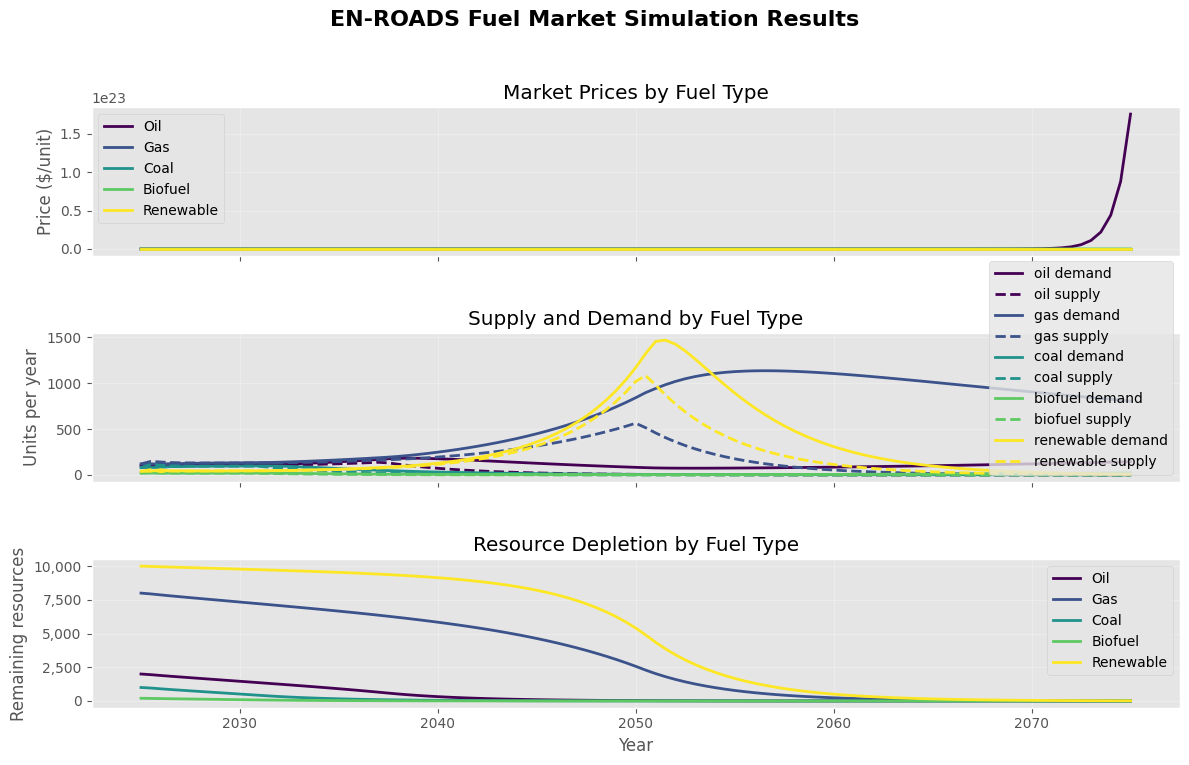

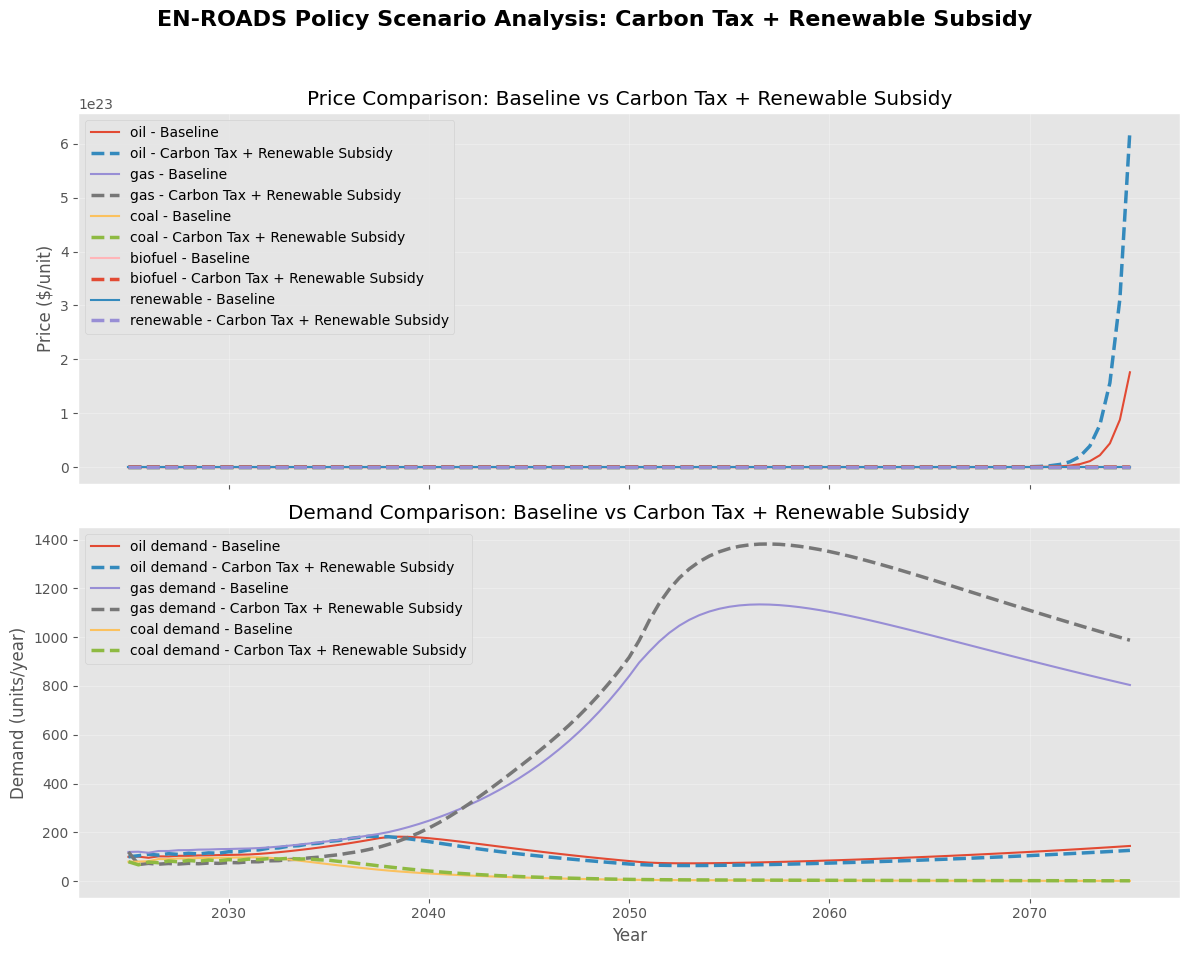

In [ ]:
# =============================================================================
# EN-ROADS-inspired Fuel Market Price Model
#
# This implementation models the dynamics of fuel market prices based on principles
# from the EN-ROADS climate simulation model, we incorporating:
#   - Supply and demand dynamics with elasticities
#   - Price adjustment mechanisms with time delays
#   - Policy interventions (taxes, subsidies, regulations)
#   - Resource depletion effects
#   - Technology learning curves
#   - Multiple fuel types and cross-elasticities
#
# Reference link is below: https://docs.climateinteractive.org/projects/en-roads-reference-guide/
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from typing import Dict, List, Tuple, Optional, Union


class FuelMarketModel:
    """
    Model for simulating fuel market price dynamics with supply-demand interactions,
    resource constraints, and policy effects.

    Based on EN-ROADS modeling principles where market prices adjust to balance
    supply and demand while accounting for resource depletion, technology learning,
    and policy interventions.
    """

    def __init__(self, start_year=2025, end_year=2100, dt=0.25):
        """
        Initialize the fuel market price model.

        Args:
            start_year: First year of simulation
            end_year: Last year of simulation
            dt: Time step in years
        """
        # Time parameters
        self.start_year = start_year
        self.end_year = end_year
        self.dt = dt
        self.years = np.arange(start_year, end_year+dt, dt)
        self.n_steps = len(self.years)

        # Default fuel types
        self.fuel_types = ['oil', 'gas', 'coal', 'biofuel', 'renewable']
        self.n_fuels = len(self.fuel_types)

        # Set default parameters
        self._set_default_parameters()

        # Initialize arrays for storing simulation results
        self._initialize_arrays()

        # Store results
        self.results = None

    def _set_default_parameters(self):
        """Define default parameters for the model based on EN-ROADS principles."""
        # Initial market prices ($/unit) - based on approximate global averages
        self.initial_prices = {
            'oil': 70.0,      # $/barrel
            'gas': 4.0,       # $/MMBtu
            'coal': 50.0,     # $/ton
            'biofuel': 80.0,  # $/barrel equivalent
            'renewable': 60.0  # $/MWh equivalent
        }

        # Base production costs ($/unit)
        self.production_costs = {
            'oil': 30.0,
            'gas': 2.0,
            'coal': 20.0,
            'biofuel': 60.0,
            'renewable': 40.0
        }

        # Price adjustment time constants (years) - how quickly prices respond to imbalances
        # From EN-ROADS: markets adjust with delays/lags in real world
        self.price_adjustment_times = {
            'oil': 0.5,
            'gas': 0.75,
            'coal': 1.0,
            'biofuel': 0.8,
            'renewable': 0.5
        }

        # Learning rates - cost reduction per doubling of cumulative production
        # Based on EN-ROADS learning curve formulation
        self.learning_rates = {
            'oil': 0.05,       # 5% cost reduction per doubling
            'gas': 0.07,
            'coal': 0.03,
            'biofuel': 0.10,
            'renewable': 0.15
        }

        # Resource depletion parameters - as resources deplete, costs increase
        # Based on EN-ROADS resource curve formulation
        self.resource_depletion_factors = {
            'oil': 0.01,       # Cost increases by this factor per unit extracted
            'gas': 0.007,
            'coal': 0.003,
            'biofuel': 0.005,
            'renewable': 0.001  # Very small depletion for renewables
        }

        # Initial resource bases (units)
        self.initial_resources = {
            'oil': 2000.0,    # Billion barrels
            'gas': 8000.0,    # Trillion cubic feet
            'coal': 1000.0,   # Billion tons
            'biofuel': 200.0, # Billion barrel equivalent
            'renewable': 10000.0  # Very large for renewables
        }

        # Demand parameters
        # Base demand at reference price (units per year)
        self.base_demands = {
            'oil': 100.0,
            'gas': 120.0,
            'coal': 80.0,
            'biofuel': 20.0,
            'renewable': 40.0
        }

        # Price elasticity of demand (dimensionless)
        # How sensitive is demand to price changes
        self.demand_elasticities = {
            'oil': -0.3,      # A 1% price increase reduces demand by 0.3%
            'gas': -0.4,
            'coal': -0.5,
            'biofuel': -0.6,
            'renewable': -0.8
        }

        # Supply parameters
        # Base supply at reference price (units per year)
        self.base_supplies = {
            'oil': 100.0,
            'gas': 120.0,
            'coal': 80.0,
            'biofuel': 20.0,
            'renewable': 40.0
        }

        # Price elasticity of supply (dimensionless)
        # How sensitive is supply to price changes
        self.supply_elasticities = {
            'oil': 0.2,       # A 1% price increase increases supply by 0.2%
            'gas': 0.3,
            'coal': 0.4,
            'biofuel': 0.7,
            'renewable': 0.9
        }

        # Cross-price elasticities
        # How demand for one fuel changes with price of another
        # A 3D dictionary: {fuel1: {fuel2: elasticity}}
        self.cross_elasticities = {
            'oil': {'gas': 0.1, 'coal': 0.05, 'biofuel': 0.2, 'renewable': 0.1},
            'gas': {'oil': 0.1, 'coal': 0.1, 'biofuel': 0.05, 'renewable': 0.1},
            'coal': {'oil': 0.05, 'gas': 0.1, 'biofuel': 0.02, 'renewable': 0.15},
            'biofuel': {'oil': 0.3, 'gas': 0.1, 'coal': 0.05, 'renewable': 0.1},
            'renewable': {'oil': 0.1, 'gas': 0.15, 'coal': 0.2, 'biofuel': 0.1}
        }

        # Policy parameters (all start at zero)
        self.taxes = {fuel: 0.0 for fuel in self.fuel_types}
        self.subsidies = {fuel: 0.0 for fuel in self.fuel_types}
        self.regulations = {fuel: 1.0 for fuel in self.fuel_types}  # Multiplier on supply (1.0 = no effect)

        # External factors
        self.gdp_growth_rate = 0.026  # 2.6% annual growth
        self.efficiency_improvement_rate = 0.01  # 1% annual improvement

        # Scale factors for visualization
        self.scale_factors = {
            'oil': 1.0,
            'gas': 10.0,  # Scale gas by 10x for better visualization
            'coal': 1.0,
            'biofuel': 1.0,
            'renewable': 0.5  # Scale renewables by 0.5x for better visualization
        }

    def _initialize_arrays(self):
        """Initialize arrays for storing simulation variables across time steps."""
        # Create dictionaries to store time series for each fuel type
        self.prices = {fuel: np.zeros(self.n_steps) for fuel in self.fuel_types}
        self.demands = {fuel: np.zeros(self.n_steps) for fuel in self.fuel_types}
        self.supplies = {fuel: np.zeros(self.n_steps) for fuel in self.fuel_types}
        self.resources = {fuel: np.zeros(self.n_steps) for fuel in self.fuel_types}
        self.production_cost_trajectories = {fuel: np.zeros(self.n_steps) for fuel in self.fuel_types}
        self.cumulative_production = {fuel: np.zeros(self.n_steps) for fuel in self.fuel_types}
        self.market_imbalances = {fuel: np.zeros(self.n_steps) for fuel in self.fuel_types}

        # Set initial values
        for fuel in self.fuel_types:
            self.prices[fuel][0] = self.initial_prices[fuel]
            self.demands[fuel][0] = self.base_demands[fuel]
            self.supplies[fuel][0] = self.base_supplies[fuel]
            self.resources[fuel][0] = self.initial_resources[fuel]
            self.production_cost_trajectories[fuel][0] = self.production_costs[fuel]
            self.cumulative_production[fuel][0] = self.base_supplies[fuel] * 10  # Assume 10 years of prior production

    def set_policy(self, policy_type: str, fuel: str, value: float, start_year: int = None, ramp_years: int = 0):
        """
        Set a policy intervention for a specific fuel.

        Args:
            policy_type: Type of policy ('tax', 'subsidy', or 'regulation')
            fuel: Fuel to apply the policy to
            value: Value of the policy ($/unit for tax/subsidy, multiplier for regulation)
            start_year: Year to start the policy (defaults to simulation start)
            ramp_years: Years to linearly phase in the policy (0 = immediate)
        """
        if fuel not in self.fuel_types:
            raise ValueError(f"Unknown fuel type: {fuel}")

        if policy_type not in ['tax', 'subsidy', 'regulation']:
            raise ValueError(f"Unknown policy type: {policy_type}")

        # Store policy settings for simulation
        if policy_type == 'tax':
            self.taxes[fuel] = value
        elif policy_type == 'subsidy':
            self.subsidies[fuel] = value
        elif policy_type == 'regulation':
            self.regulations[fuel] = value

        # NOTE: In a full implementation, you would apply this policy during
        # the simulation based on start_year and ramp_years

    def _update_production_costs(self, t: int, fuel: str):
        """
        Update production costs based on resource depletion and technology learning.
        Uses EN-ROADS style formulations for both effects.

        Args:
            t: Current time step
            fuel: Fuel type to update
        """
        # Calculate cumulative production
        if t > 0:
            self.cumulative_production[fuel][t] = (
                self.cumulative_production[fuel][t-1] + self.supplies[fuel][t-1] * self.dt
            )

        # Calculate resource depletion effect (costs increase as resources deplete)
        # Based on EN-ROADS resource curve formulation
        resource_remaining = self.resources[fuel][t] / self.initial_resources[fuel]
        depletion_multiplier = 1.0 + max(0, 1.0 - resource_remaining) * self.resource_depletion_factors[fuel]

        # Calculate learning effect (costs decrease as cumulative production increases)
        # Based on EN-ROADS learning curve formulation
        if t > 0:
            learning_ratio = self.cumulative_production[fuel][t] / self.cumulative_production[fuel][0]
            learning_multiplier = learning_ratio ** (-self.learning_rates[fuel])
        else:
            learning_multiplier = 1.0

        # Combined effect
        self.production_cost_trajectories[fuel][t] = (
            self.production_costs[fuel] * depletion_multiplier * learning_multiplier
        )

    def _calculate_demand(self, t: int, fuel: str):
        """
        Calculate demand for a fuel based on price, elasticity, and cross-elasticities.

        Args:
            t: Current time step
            fuel: Fuel type to calculate demand for
        """
        # Base effect of own price on demand (EN-ROADS uses log-linear formulation)
        # Formula: Demand = BaseValue * (Price/ReferencePrice)^Elasticity
        effective_price = self.prices[fuel][t-1] + self.taxes[fuel] - self.subsidies[fuel]
        own_price_effect = (effective_price / self.initial_prices[fuel]) ** self.demand_elasticities[fuel]

        # Cross-price effects from other fuels
        cross_price_effect = 1.0
        for other_fuel in self.fuel_types:
            if other_fuel != fuel:
                other_price = self.prices[other_fuel][t-1] + self.taxes[other_fuel] - self.subsidies[other_fuel]
                price_ratio = other_price / self.initial_prices[other_fuel]
                cross_elasticity = self.cross_elasticities[fuel][other_fuel]
                cross_price_effect *= price_ratio ** cross_elasticity

        # Calculate GDP effect on demand (income elasticity)
        # Simple exponential growth based on years from start
        years_elapsed = (t * self.dt)
        gdp_multiplier = (1 + self.gdp_growth_rate) ** years_elapsed

        # Energy efficiency improvements over time
        efficiency_multiplier = (1 - self.efficiency_improvement_rate) ** years_elapsed

        # Combine all effects
        self.demands[fuel][t] = (
            self.base_demands[fuel] * own_price_effect * cross_price_effect *
            gdp_multiplier * efficiency_multiplier
        )

    def _calculate_supply(self, t: int, fuel: str):
        """
        Calculate supply of a fuel based on price, cost, elasticity and regulations.

        Args:
            t: Current time step
            fuel: Fuel type to calculate supply for
        """
        # Price to cost ratio affects supply (EN-ROADS uses profit-driven supply)
        price_cost_ratio = self.prices[fuel][t-1] / self.production_cost_trajectories[fuel][t-1]

        # EN-ROADS style supply response (non-linear)
        # Supply increases more than proportionally as price rises above cost
        supply_factor = price_cost_ratio ** self.supply_elasticities[fuel]

        # Apply regulatory constraints
        regulatory_effect = self.regulations[fuel]

        # Calculate new supply
        new_supply = self.base_supplies[fuel] * supply_factor * regulatory_effect

        # Check resource constraints - can't extract more than what's available
        max_extractable = self.resources[fuel][t-1] / self.dt * 0.1  # Max 10% of remaining resource per year
        self.supplies[fuel][t] = min(new_supply, max_extractable)

        # Update remaining resources
        if t > 0:
            self.resources[fuel][t] = self.resources[fuel][t-1] - self.supplies[fuel][t-1] * self.dt

    def _update_price(self, t: int, fuel: str):
        """
        Update price based on supply-demand imbalance with delay.

        Args:
            t: Current time step
            fuel: Fuel type to update price for
        """
        # Calculate market imbalance
        imbalance = self.demands[fuel][t] - self.supplies[fuel][t]
        self.market_imbalances[fuel][t] = imbalance

        # Normalized imbalance as percentage of demand
        if self.demands[fuel][t] > 0:
            normalized_imbalance = imbalance / self.demands[fuel][t]
        else:
            normalized_imbalance = 0

        # Price adjustment proportional to imbalance with time delay
        # Based on EN-ROADS price adjustment mechanism
        adjustment_speed = self.dt / self.price_adjustment_times[fuel]

        # Non-linear response - larger imbalances cause faster price changes
        # Formula based on EN-ROADS: larger imbalances → faster price changes
        price_change = self.prices[fuel][t-1] * normalized_imbalance * adjustment_speed

        # Apply price change
        self.prices[fuel][t] = max(self.production_cost_trajectories[fuel][t] * 0.8,  # Price floor
                                  self.prices[fuel][t-1] + price_change)

    def run_simulation(self):
        """
        Run the full market simulation for all fuels and time steps.

        Returns:
            DataFrame with simulation results
        """
        # Main simulation loop
        for t in range(1, self.n_steps):
            for fuel in self.fuel_types:
                # Update production costs (technology + depletion effects)
                self._update_production_costs(t, fuel)

                # Calculate demand and supply
                self._calculate_demand(t, fuel)
                self._calculate_supply(t, fuel)

                # Update price based on market dynamics
                self._update_price(t, fuel)

        # Format results as DataFrame
        self._compile_results()
        return self.results

    def _compile_results(self):
        """Compile simulation results into a pandas DataFrame."""
        data = {'Year': self.years}

        # Add data for each fuel type
        for fuel in self.fuel_types:
            data[f'{fuel}_price'] = self.prices[fuel]
            data[f'{fuel}_demand'] = self.demands[fuel]
            data[f'{fuel}_supply'] = self.supplies[fuel]
            data[f'{fuel}_resource'] = self.resources[fuel]
            data[f'{fuel}_cost'] = self.production_cost_trajectories[fuel]
            data[f'{fuel}_imbalance'] = self.market_imbalances[fuel]

        self.results = pd.DataFrame(data)
        return self.results

    def plot_results(self, metrics=None, fuels=None, figsize=(12, 8), style='ggplot'):
        """
        Plot simulation results for specified metrics and fuels.

        Args:
            metrics: List of metrics to plot ['price', 'demand', 'supply', 'resource', 'cost']
            fuels: List of fuels to include (defaults to all)
            figsize: Figure size tuple
            style: Matplotlib style
        """
        if self.results is None:
            raise ValueError("You must run the simulation before plotting results")

        # Default metrics and fuels
        if metrics is None:
            metrics = ['price', 'demand_supply']

        if fuels is None:
            fuels = self.fuel_types

        # Set plot style
        plt.style.use(style)

        # Calculate subplots
        n_plots = len(metrics)
        fig, axes = plt.subplots(n_plots, 1, figsize=figsize, sharex=True)
        if n_plots == 1:
            axes = [axes]

        colors = plt.cm.viridis(np.linspace(0, 1, len(fuels)))
        color_dict = {fuel: colors[i] for i, fuel in enumerate(fuels)}

        # Format for y-axis with commas for thousands
        def format_with_commas(x, pos):
            return f'{x:,.0f}'

        for i, metric in enumerate(metrics):
            ax = axes[i]

            if metric == 'price':
                for fuel in fuels:
                    ax.plot(self.results['Year'], self.results[f'{fuel}_price'],
                            label=f'{fuel.capitalize()}', color=color_dict[fuel], linewidth=2)
                ax.set_ylabel('Price ($/unit)')
                ax.set_title('Market Prices by Fuel Type')

            elif metric == 'demand_supply':
                for fuel in fuels:
                    # Plot with markers for better distinction between lines
                    ax.plot(self.results['Year'], self.results[f'{fuel}_demand'],
                            label=f'{fuel} demand', color=color_dict[fuel], linewidth=2)
                    ax.plot(self.results['Year'], self.results[f'{fuel}_supply'],
                            label=f'{fuel} supply', color=color_dict[fuel], linewidth=2,
                            linestyle='--')
                ax.set_ylabel('Units per year')
                ax.set_title('Supply and Demand by Fuel Type')

            elif metric == 'resource':
                for fuel in fuels:
                    ax.plot(self.results['Year'], self.results[f'{fuel}_resource'],
                            label=f'{fuel.capitalize()}', color=color_dict[fuel], linewidth=2)
                ax.set_ylabel('Remaining resources')
                ax.yaxis.set_major_formatter(FuncFormatter(format_with_commas))
                ax.set_title('Resource Depletion by Fuel Type')

            elif metric == 'cost':
                for fuel in fuels:
                    ax.plot(self.results['Year'], self.results[f'{fuel}_cost'],
                            label=f'{fuel.capitalize()}', color=color_dict[fuel], linewidth=2)
                ax.set_ylabel('Production cost ($/unit)')
                ax.set_title('Production Costs by Fuel Type')

            elif metric == 'imbalance':
                for fuel in fuels:
                    ax.plot(self.results['Year'], self.results[f'{fuel}_imbalance'],
                            label=f'{fuel.capitalize()}', color=color_dict[fuel], linewidth=2)
                ax.set_ylabel('Demand - Supply')
                ax.set_title('Market Imbalance by Fuel Type')
                ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

            ax.grid(True, alpha=0.3)
            ax.legend()

        # Common x-axis label
        axes[-1].set_xlabel('Year')

        # Title for the entire figure
        fig.suptitle('EN-ROADS Fuel Market Simulation Results', fontsize=16, fontweight='bold')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        return fig, axes

    def run_policy_scenario(self, scenario_name, policies, plot=True):
        """
        Run a policy scenario and compare to baseline.

        Args:
            scenario_name: Name of the scenario
            policies: List of policy dictionaries:
                      [{'type': 'tax', 'fuel': 'oil', 'value': 20.0}]
            plot: Whether to plot results

        Returns:
            DataFrame with scenario results
        """
        # Store baseline results if not already run
        if self.results is None:
            baseline = self.run_simulation()
        else:
            baseline = self.results.copy()

        # Reset the model
        self._initialize_arrays()

        # Apply policies
        for policy in policies:
            self.set_policy(policy['type'], policy['fuel'], policy['value'])

        # Run with policies
        scenario_results = self.run_simulation()
        scenario_results['scenario'] = scenario_name

        # Add scenario marker to baseline for comparison
        baseline_marked = baseline.copy()
        baseline_marked['scenario'] = 'Baseline'

        # Combine results
        combined_results = pd.concat([baseline_marked, scenario_results])

        # Plot if requested
        if plot:
            self._plot_scenario_comparison(combined_results, scenario_name)

        return combined_results

    def _plot_scenario_comparison(self, combined_results, scenario_name):
        """
        Plot comparison between baseline and a policy scenario.

        Args:
            combined_results: DataFrame with both baseline and scenario results
            scenario_name: Name of the scenario for the title
        """
        # Set of fuels to show
        fuels = self.fuel_types

        fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        # Plot price comparison
        for fuel in fuels:
            # Get data for each scenario
            baseline_data = combined_results[combined_results['scenario'] == 'Baseline']
            scenario_data = combined_results[combined_results['scenario'] == scenario_name]

            # Plot price comparison
            axes[0].plot(baseline_data['Year'], baseline_data[f'{fuel}_price'],
                        label=f'{fuel} - Baseline', linestyle='-', linewidth=1.5)
            axes[0].plot(scenario_data['Year'], scenario_data[f'{fuel}_price'],
                        label=f'{fuel} - {scenario_name}', linestyle='--', linewidth=2.5)

        axes[0].set_ylabel('Price ($/unit)')
        axes[0].set_title(f'Price Comparison: Baseline vs {scenario_name}')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

        # Plot demand comparison for a subset of fuels
        # Just showing a few fuels for clarity
        focus_fuels = fuels[:3]  # First three fuels

        for fuel in focus_fuels:
            # Get data for each scenario
            baseline_data = combined_results[combined_results['scenario'] == 'Baseline']
            scenario_data = combined_results[combined_results['scenario'] == scenario_name]

            # Plot demand comparison
            axes[1].plot(baseline_data['Year'], baseline_data[f'{fuel}_demand'],
                        label=f'{fuel} demand - Baseline', linestyle='-', linewidth=1.5)
            axes[1].plot(scenario_data['Year'], scenario_data[f'{fuel}_demand'],
                        label=f'{fuel} demand - {scenario_name}', linestyle='--', linewidth=2.5)

        axes[1].set_ylabel('Demand (units/year)')
        axes[1].set_xlabel('Year')
        axes[1].set_title(f'Demand Comparison: Baseline vs {scenario_name}')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()

        fig.suptitle(f'EN-ROADS Policy Scenario Analysis: {scenario_name}', fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


# Example usage
if __name__ == "__main__":
    # Create and run the model with default parameters
    model = FuelMarketModel(start_year=2025, end_year=2075, dt=0.5)
    results = model.run_simulation()

    # Print summary of results
    print("=== Fuel Market Model Results ===")
    print(f"Years: {model.start_year} to {model.end_year}")
    print("\nInitial values:")
    for fuel in model.fuel_types:
        print(f"  {fuel}: Price=${model.initial_prices[fuel]:.2f}, " +
              f"Demand={model.base_demands[fuel]:.1f}, " +
              f"Supply={model.base_supplies[fuel]:.1f}")

    print("\nFinal values (year 2075):")
    for fuel in model.fuel_types:
        last_idx = -1
        print(f"  {fuel}: Price=${model.prices[fuel][last_idx]:.2f}, " +
              f"Demand={model.demands[fuel][last_idx]:.1f}, " +
              f"Supply={model.supplies[fuel][last_idx]:.1f}, " +
              f"Resources={model.resources[fuel][last_idx]:.1f}")

    # Plot standard results
    model.plot_results(metrics=['price', 'demand_supply', 'resource'])

    # Run a policy scenario
    carbon_tax_scenario = [
        {'type': 'tax', 'fuel': 'oil', 'value': 30.0},
        {'type': 'tax', 'fuel': 'gas', 'value': 15.0},
        {'type': 'tax', 'fuel': 'coal', 'value': 40.0},
        {'type': 'subsidy', 'fuel': 'renewable', 'value': 20.0}
    ]

    combined_results = model.run_policy_scenario("Carbon Tax + Renewable Subsidy", carbon_tax_scenario)